In [94]:
"""
Script to process all the LCDRI data, generate 1D surface wave spectra, and calculate significant wave heights

"""


from scipy.io import loadmat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_theta_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
big_spec_store = []
resid_store = np.array([])
up_normals = np.array([])
up_mags = np.array([])
down_mags = np.array([])
down_normals = np.array([])
big_rotp_store = []


big_mag_store = []

#For investigating down profiles
#down_min_z = []
#up_min_z =[]


up = True
overall_counter = 0
float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    theta_store = np.zeros((len(efr_files), 59))
    spec_store = np.zeros((len(efr_files), 2, 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    rotp_store = np.zeros(len(efr_files))
    mag_store = np.zeros((len(efr_files), 3))
    counter=0
    
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
            
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #CHANGE THIS BACK TO AZ
        AZ = (EFR["AZ"][0, :]-(2**9))/((2**10)/4)
        AX = (EFR["AX"][0, :]-(2**9))/((2**10)/4)
        AY = (EFR["AY"][0, :]-(2**9))/((2**10)/4)
        #AZ = AZ-np.nanmean(AZ)
        AZ = signal.detrend(AZ)
        facg=9.81
        AZ=AZ*facg
        

        #AY = AY-np.nanmean(AY)
        AY = signal.detrend(AY)
        facg=9.81
        AY=AY*facg


        #AX = AX-np.nanmean(AX)
        AY = signal.detrend(AX)
        facg=9.81
        AX=AX*facg



        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            AZ = np.flip(AZ)
            AX = np.flip(AX)
            AY = np.flip(AY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Uncomment this to print out the filenames where EM starts before CTD
        #if len(moving_inds)<len(Pef):
            #print(len(Pef)-len(moving_inds), fname)
            #continue
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        HZ = HZ[moving_inds]
        AX = AX[moving_inds]
        AY = AY[moving_inds]
        AZ = AZ[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef_moving = Pef[moving_inds]
        
        
        #HX, HY = correct_mag(HX, HY, HZ)
        
        
        hx = (HX-np.nanmean(HX))/np.std(HX)/np.sqrt(2)
        hy = (HY-np.nanmean(HY))/np.std(HY)/np.sqrt(2)
        hz = (HZ-np.nanmean(HZ))/np.std(HZ)/np.sqrt(2)

        

       # P = np.append(np.expand_dims(hx, axis=1), np.expand_dims(hy, axis=1), axis=1)
        #P = np.append(P, np.expand_dims(hz, axis=1), axis=1)
        #P_mean = P.mean(axis=0)
        #P_centered = P - P_mean
        #U,s,V = linalg.svd(P_centered)
        

        #normal = V[2,:]
        
        
        if not up:
            HZd = HZ;
            HYd = HY;
            HXd = HX;
        
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        [AZoffs,AZ2offs,AZfits,AZ2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,AZ,AZ,HX,HY) 
        [AYoffs,AY2offs,AYfits,AY2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,AY,AY,HX,HY) 
        [AXoffs,AX2offs,AXfits,AX2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,AX,AX,HX,HY) 



        
        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);
            
            AZfit = np.nanmean(AZfits, 1)
            AXfit = np.nanmean(AXfits, 1)
            AYfit = np.nanmean(AYfits, 1)



        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit
        
        AZr = AZ - AZfit
        AXr = AX - AXfit
        AYr = AY - AYfit

        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        #Rotate into x-y properly based on alpha1 angle offset btwn hx and Electrodes
        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        AZr_filtered = signal.sosfilt(sos, AZr)
        
        E_x_filt = E_x_filtered
        E_y_filt = E_y_filtered
        #AZr = AZr_filtered
    
        ##Get the mean residual level below 90m for the purpose of estimating error
        deep_inds = np.where(Pef_moving>=90)
        error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
        resid_store = np.append(resid_store, error)
        
        
        #Now take the spectra
        nblock = 120
        fs = 1
        overlap = 60
        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        
      
                
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)

        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        #Reshape the acceleration data
        [az_reshaped, z_az] = reshape_u(AZ, Pef, nblock, overlap, fs)
        
        [azr_reshaped, z_az] = reshape_u(AZr, Pef, nblock, overlap, fs)
        [axr_reshaped, z_az] = reshape_u(AXr, Pef, nblock, overlap, fs)
        [ayr_reshaped, z_az] = reshape_u(AYr, Pef, nblock, overlap, fs)





        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

        zero_inds = np.where(prof_speed==0)[0]
        #if len(zero_inds)>0:
            #print(z_x[0, :])
        
        
        

        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)
        
        specs = make_spectra(u_x, u_y, az_reshaped, fs)
        
        
        [u_y_filt, z_y] = reshape_u(E_y_filt, Pef, nblock, overlap, fs)
        [u_x_filt, z_y] = reshape_u(E_x_filt, Pef, nblock, overlap, fs)



        UUwindow, fwindow = make_vel_spectrum(u_x_filt, fs)
        VVwindow, fwindow = make_vel_spectrum(u_y_filt, fs)
        AZAZwindow, fwindow = make_az_spectrum(az_reshaped, fs)
        AZrAZrwindow, fwindow = make_az_spectrum(azr_reshaped, fs)
        AXrAXrwindow, fwindow = make_az_spectrum(axr_reshaped, fs)
        AYrAYrwindow, fwindow = make_az_spectrum(ayr_reshaped, fs)


        
        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
        else:  
            min_bin = np.append(min_bin, min_z)
            first_bot = np.append(first_bot, z_x[0, -1])

            #displacement spectra for horizontal components
            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            Eh = Exx+Eyy
            
            #Displacement Spectra for vertical component
            ZZ = AZAZwindow/(int(nblock/2)*fs)
            ZZr = AZrAZrwindow/(int(nblock/2)*fs)
            XXr = AXrAXrwindow/(int(nblock/2)*fs)
            YYr = AYrAYrwindow/(int(nblock/2)*fs)

            #This has to get raised to the 4th power to go from Accel -> displacement
            Ezz = ZZ[:, 1:]/ (np.square(np.square((2*np.pi*fwindow[1:]))))
            Ezzr = ZZr[:, 1:]/ (np.square(np.square((2*np.pi*fwindow[1:]))))


            
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            u_noise = 0 #This is just for testing...
            [lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
         
        
            [Ez_Eric1, Ez_Eric2, Ez_Eric3, Ez_Eric4] = depth_correct_Eric(Ezz, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            [Ezr_Eric1, Ezr_Eric2, Ezr_Eric3, Ezr_Eric4] = depth_correct_Eric(Ezzr, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)


        
            UV = (specs.UV/(int(nblock/2)*fs))[:, 1:]
            UAZ = (specs.UAZ/(int(nblock/2)*fs))[:, 1:]
            VAZ = (specs.VAZ/(int(nblock/2)*fs))[:, 1:]
            
            UV = np.nanmean(UV, axis=0)
            UAZ = np.nanmean(UAZ, axis=0)
            VAZ = np.nanmean(VAZ, axis=0)
            Exx = np.nanmean(Exx, axis=0)
            Eyy = np.nanmean(Eyy, axis=0)
            Ezz = np.nanmean(Ezz, axis=0)
            Ezzr = np.nanmean(Ezzr, axis=0)
            
            Cxz = np.real(UAZ) / ( np.power(2*np.pi*fwindow[1:], 3) )
            Cyz = np.real(VAZ) / ( np.power(2*np.pi*fwindow[1:], 3) )
            Cxy = np.real(UV) / ( np.power(2*np.pi*fwindow[1:], 3) )
            a1 = Cxz / np.sqrt((Exx+Eyy) * Ezzr)
            b1 = Cyz / np.sqrt((Exx+Eyy) * Ezzr)
            a2 = (Exx - Eyy) / (Exx + Eyy)
            b2 = 2 * Cxy / ( Exx + Eyy)
            theta = np.arctan2(a1, b1)
            theta2 = np.arctan2(a2, b2)
            
            
            for ind in range(len(theta)):
                if theta[ind]<0:
                    theta[ind]= theta[ind] + 2*np.pi
                if theta2[ind]<0:
                    theta2[ind]=theta2[ind] + 2*np.pi
            theta_fixed = theta*180/np.pi + 90
            inds = theta_fixed>360
            theta_fixed[inds] = theta_fixed[inds]-360
            
            mag_store_temp = np.array([[((HX-np.nanmean(HX))/np.std(HX)/np.sqrt(2))], [((HY-np.nanmean(HY))/np.std(HY)/np.sqrt(2))], [((HZ-np.nanmean(HZ))/np.std(HZ)/np.sqrt(2))]])
        
            
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                theta_store[counter, :] = theta_fixed
                time_store[counter] = np.nanmean(mlt_efr)
                prof_store[counter] = float_id+"_"+str(prof_num)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)

                
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0

        
        
            counter+=1
        
            
            #Want a like [Mx3] sized array where M is total number of individual mag samples over all floats.
            if overall_counter==0:
                big_mag_store=mag_store_temp[:, 0, :].T
        
            else:
                big_mag_store = np.append(big_mag_store, mag_store_temp[:, 0, :].T, axis=0)
                
            overall_counter+=1
            
        
        if up:
            #up_normals = np.append(up_normals, normal[2])
            up_mags = np.append(up_mags, np.nanquantile(AZfit, 0.9))
        else:
            #down_normals = np.append(down_normals, normal[2])
            down_mags = np.append(down_mags, np.nanquantile(AZfit, 0.9))


            
    if float_id_counter==0:
        big_theta_store=theta_store
        big_time_store = time_store
        big_up_down_store = up_down_store
        big_prof_store = prof_store
        big_spec_store = spec_store
        
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_theta_store = np.append(big_theta_store, theta_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)
        big_prof_store = np.append(big_prof_store, prof_store)
        
        

    
    float_id_counter+=1
                    

In [12]:
#Getting rid of the profiles where minimum depth was below 20m
kill = np.where(big_spec_store[:, 0, 5]==0)


spec_store_shallow = np.delete(big_spec_store, kill[0], axis=0)
theta_store_shallow = np.delete(big_theta_store, kill[0], axis=0)
time_store_shallow = np.delete(big_time_store, kill[0], axis=0)
up_down_store_shallow = np.delete(big_up_down_store, kill[0], axis=0)

out = zip(spec_store_shallow, theta_store_shallow, up_down_store_shallow, time_store_shallow)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: tup[3])

unzipped = ([ a for a,b,c,d in sorted_array ], [ b for a,b,c,d in sorted_array ], [c for a,b,c,d in sorted_array], [d for a,b,c,d in sorted_array])

spec_store_sorted = np.array(unzipped[0])
theta_store_sorted = np.array(unzipped[1])
up_down_store_sorted = np.array(unzipped[2])
time_store_sorted = np.array(unzipped[3])


In [13]:

fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = [datetime.datetime.fromtimestamp(t) for t in times]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])
cdip_directions = nc.variables['waveMeanDirection'][:]



In [14]:
##Get Errors
#first need to match up teh 



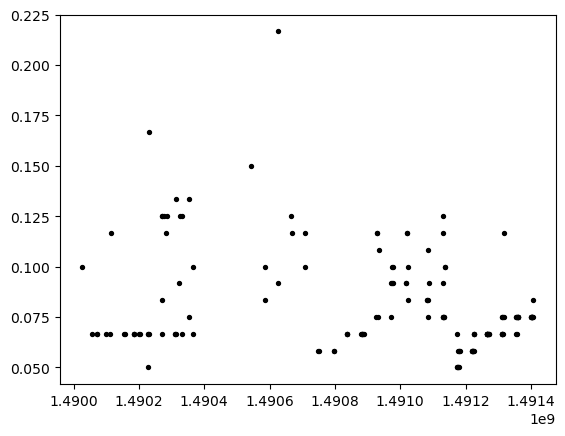

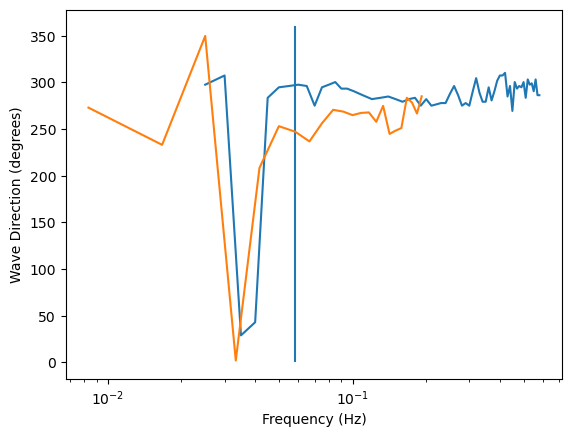

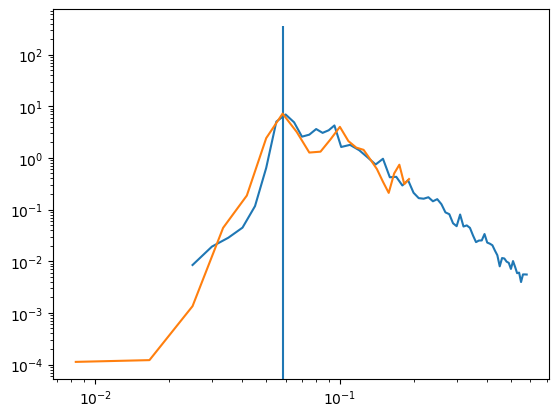

In [78]:
%matplotlib inline
ind = 50

ind2 = np.where(np.abs(np.nanmean(time_store_sorted[ind])-times)==np.min(np.abs(np.nanmean(time_store_sorted[ind])-times)))[0]
#plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
cdip_dir = cdip_directions[ind2, :]

[peak_freq, peak_spl] = get_peak_freq(fwindow[1:], spec_store_sorted[:, 1, :])
plt.scatter(time_store_sorted, peak_freq, color='k', s=8, label="EM-APEX")

[peak_freq_cdip, peak_spl_cdip] = get_peak_freq(wave_freq, energy_density)
first_nan = np.isnan(spec_store_sorted[ind, 1, :])
plt.figure()
plt.plot(wave_freq, np.transpose(cdip_dir))
plt.vlines(x=peak_freq[ind], ymin=0, ymax=360)
#plt.plot(fwindow[1:], theta*180/np.pi)
#plt.plot(fwindow[1:], theta2*180/np.pi)
theta_store_sorted[ind, first_nan]=np.nan
plt.plot(fwindow[1:], theta_store_sorted[ind, :])
#plt.plot(fwindow[1:], theta2_fixed)
swell_band = [0.06, 0.11]

plt.xlabel("Frequency (Hz)")
plt.ylabel("Wave Direction (degrees)")
plt.xscale('log')

plt.figure()
plt.loglog(wave_freq, np.transpose(energy_density[ind2]))
plt.loglog(fwindow[1:], spec_store_sorted[ind, 1, :])
plt.vlines(x=peak_freq[ind], ymin=0, ymax=360)

peak_dir_err = np.array([])
peak_dir_em = np.array([])
peak_dir_cdip = np.array([])


#Plot the actual directional errors
#plt.figure()
for spec_ind in range(len(peak_freq)):
    ind2 = np.where(np.abs(np.nanmean(time_store_sorted[spec_ind])-times)==np.min(np.abs(np.nanmean(time_store_sorted[spec_ind])-times)))[0]
    cdip_dir = cdip_directions[ind2, :]
    
    dir_ind = np.argwhere(fwindow[1:]==peak_freq[spec_ind])
    cdip_dir_ind = np.argwhere(wave_freq==peak_freq_cdip[ind2])
    diff = np.abs(theta_store_sorted[ind, dir_ind]-cdip_dir.T[cdip_dir_ind])
    if diff>180:
        diff = diff-360
    peak_dir_err = np.append(peak_dir_err, np.array([diff]))
    peak_dir_em = np.append(peak_dir_em, np.array([theta_store_sorted[ind, dir_ind]]))
    peak_dir_cdip = np.append(peak_dir_cdip, np.array(cdip_dir.T[cdip_dir_ind]))
    #print(theta_store_sorted[ind, dir_ind], cdip_dir.T[cdip_dir_ind])

peak_dir_cdip_all = np.array([])


#All cdip peak directions
for spec_ind in range(len(peak_freq_cdip)):
    cdip_dir_ind = np.argwhere(wave_freq==peak_freq_cdip[spec_ind])
    peak_dir_cdip_all = np.append(peak_dir_cdip_all, np.array(cdip_directions[spec_ind, cdip_dir_ind]))
    




#peak_freq-peak_freq_cdip

Text(0.5, 1.0, 'EM-APEX and CDIP peak wave directions')

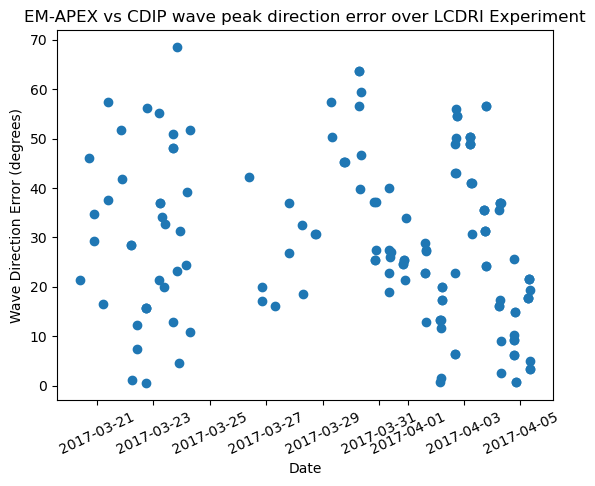

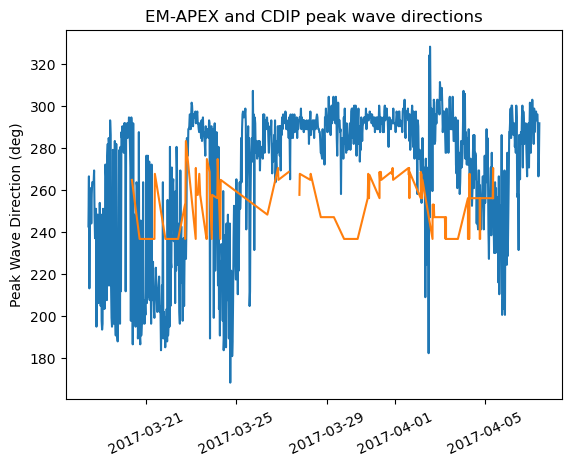

In [89]:
ts = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted])
ts_cdip = np.array([datetime.datetime.fromtimestamp(t) for t in times])



plt.scatter(ts, peak_dir_err)
plt.xticks( rotation=25 )
plt.xlabel("Date")
plt.ylabel("Wave Direction Error (degrees)")
plt.title("EM-APEX vs CDIP wave peak direction error over LCDRI Experiment")

np.nanmean(peak_dir_err)
2*np.nanstd(peak_dir_err)


plt.figure()

plt.plot(ts_cdip, peak_dir_cdip_all, label="CDIP")
plt.plot(ts, peak_dir_em, label="EM-APEX")
plt.xticks( rotation=25 )
plt.ylabel("Peak Wave Direction (deg)")
plt.title("EM-APEX and CDIP peak wave directions")


In [76]:
cdip_dir_ind

array([[6]])

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_56727/3321466497.py:1: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:], np.nanmean(Ez_Eric4, axis=0), label="vertial acceleration spectrum")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_56727/3321466497.py:2: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0), label="horizontal veocity spectrum")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_56727/3321466497.py:4: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:], np.nanmean(Ezr_Eric4, axis=0), 'r', label="corrected vertial acceleration spectrum")


Text(0.5, 0, 'Frequency')

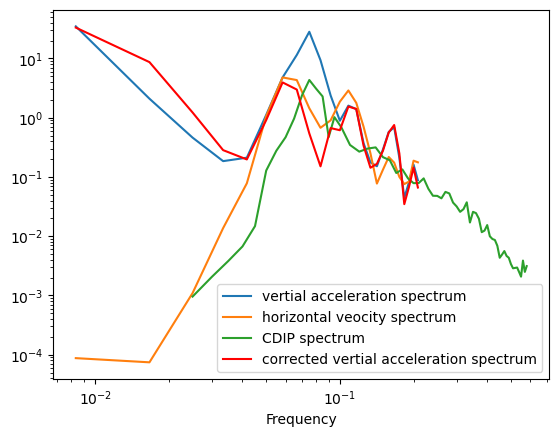

In [95]:
plt.loglog(fwindow[1:], np.nanmean(Ez_Eric4, axis=0), label="vertial acceleration spectrum")
plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0), label="horizontal veocity spectrum")
plt.loglog(wave_freq, (energy_density[ind2, :][0, :]), label="CDIP spectrum")
plt.loglog(fwindow[1:], np.nanmean(Ezr_Eric4, axis=0), 'r', label="corrected vertial acceleration spectrum")
plt.legend()
plt.xlabel("Frequency")
#plt.loglog(fwindow[1:], np.nanmean(Eh_Eric4, axis=0))
#plt.loglog(fwindow[1:], np.nanmean(Ez_Eric4, axis=0))

Text(0, 0.5, 'Wave Direction (degrees)')

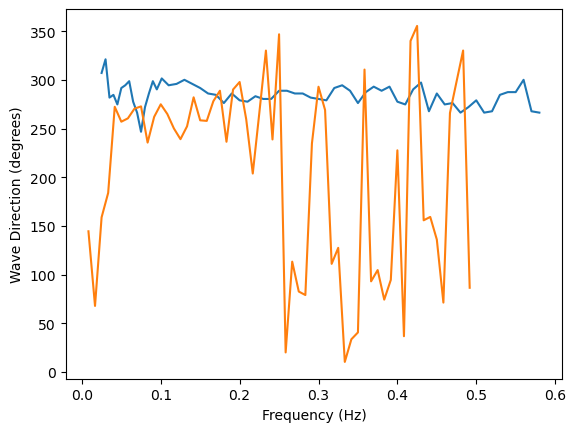

In [8]:
plt.plot(wave_freq, np.transpose(cdip_dir))
#plt.plot(fwindow[1:], theta*180/np.pi)
#plt.plot(fwindow[1:], theta2*180/np.pi)
plt.plot(fwindow[1:], theta_fixed)
#plt.plot(fwindow[1:], theta2_fixed)
swell_band = [0.06, 0.11]

plt.xlabel("Frequency (Hz)")
plt.ylabel("Wave Direction (degrees)")

In [54]:
plt.loglog(fwindow[1:], 2*Ezzr)
plt.loglog(fwindow[1:], Exx+Eyy)
plt.loglog(wave_freq, (energy_density[ind2, :][0, :]))

array([232.23105027,  69.31810812, 159.7353023 , 183.58245039,
       272.55774089, 257.2181699 , 260.64916953, 270.57237068,
       272.96355698, 235.74081458, 262.23508105, 275.10092491,
       265.12188645, 250.27065535, 239.26638166, 252.44697075,
       282.27131753, 258.63194555, 258.0547928 , 278.27002329,
       289.06404054, 236.60060813, 290.28034629, 298.03162087,
       259.79798315, 203.93562223, 266.47314071, 330.33341988,
       238.95870373, 347.0775355 ,  20.02730238, 113.32446116,
        82.60811998,  79.03482869, 234.85577215, 293.16031803,
       269.22832534, 111.07743411, 127.54115166,  10.26769838,
        33.54360737,  40.60687656, 310.81115066,  93.1065379 ,
       104.687556  ,  74.29879574,  94.59380603, 227.79655992,
        36.6878441 , 340.25033127, 355.67494503, 155.85451596,
       159.3250752 , 136.0864548 ,  71.25638714, 266.22443291,
       298.38353755, 330.37440537,  86.4947964 ])

Text(0.5, 0, 'Depth')

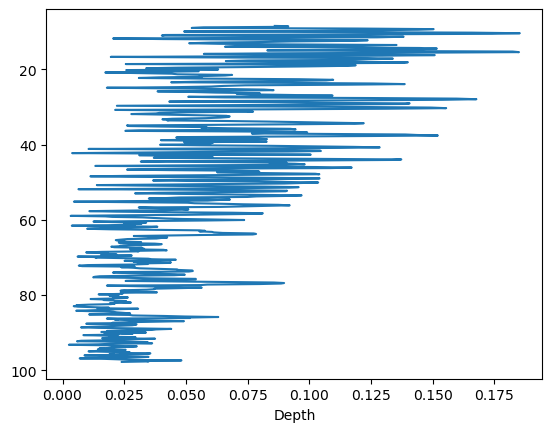

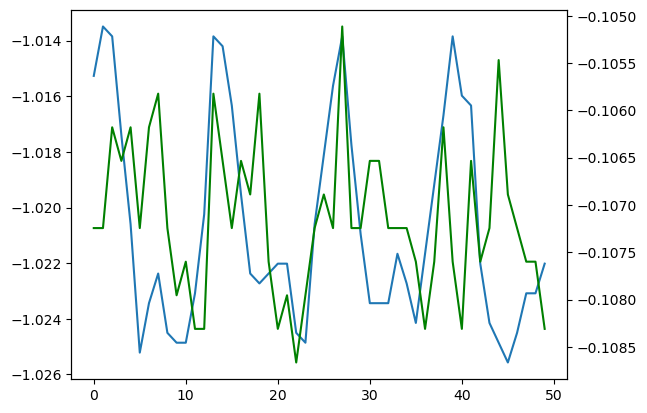

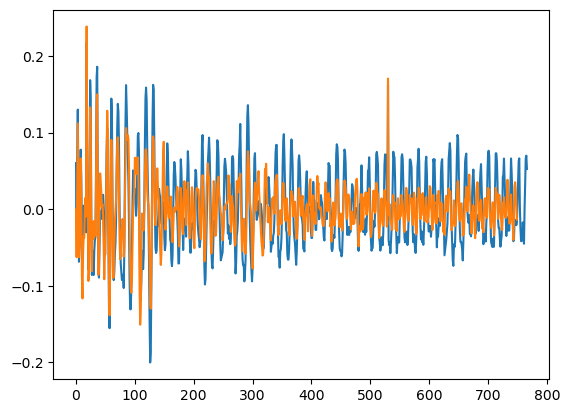

In [99]:
AZ_std = (EFR["AZ"][0, :]-(2**9))/((2**10)/4)
AX = (EFR["AX"][0, :]-(2**9))/((2**10)/4)
AY = (EFR["AY"][0, :]-(2**9))/((2**10)/4)


fig, ax1 = plt.subplots()
ax1.plot(AZ_std[:50])
ax2 = ax1.twinx()
ax2.plot(AX[:50], color='g')

mag = np.sqrt(AX**2+AY**2+AZ_std**2)
plt.figure()
plt.plot(AZ)
plt.plot(AZr)

In [27]:
from numpy import *
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

#-------------------------------------------------------------------------------
# FIT CIRCLE 2D
# - Find center [xc, yc] and radius r of circle fitting to set of 2D points
# - Optionally specify weights for points
#
# - Implicit circle function:
#   (x-xc)^2 + (y-yc)^2 = r^2
#   (2*xc)*x + (2*yc)*y + (r^2-xc^2-yc^2) = x^2+y^2
#   c[0]*x + c[1]*y + c[2] = x^2+y^2
#
# - Solution by method of least squares:
#   A*c = b, c' = argmin(||A*c - b||^2)
#   A = [x y 1], b = [x^2+y^2]
#-------------------------------------------------------------------------------
def fit_circle_2d(x, y, w=[]):
    
    A = np.array([x, y, ones(len(x))]).T
    b = x**2 + y**2
    A = np.array([x**2, x * y, y**2, x, y]).T
    b = np.ones_like(x)
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = diag(w)
        A = dot(W,A)
        b = dot(W,b)
    
    # Solve by method of least squares
    c = linalg.lstsq(A,b,rcond=None)[0]
    
    # Get circle parameters from solution c
    xc = c[0]/2
    yc = c[1]/2
    r = sqrt(c[2] + xc**2 + yc**2)
    
    #Retrun ellipse params:
    A=c[0]
    B=c[1]
    C=c[2]
    D=c[3]
    E=c[4]
    F=-1
    #eqn for major and minor axes of ellipse
    a = - np.sqrt(2*(A*(E**2)+C*(D**2)-B*D*E+((B**2)-4*A*C)*F)*((A+C)+np.sqrt(((A-C)**2)+(B**2))))/((B**2)-4*A*C)
    b = - np.sqrt(2*(A*(E**2)+C*(D**2)-B*D*E+((B**2)-4*A*C)*F)*((A+C)-np.sqrt(((A-C)**2)+(B**2))))/((B**2)-4*A*C)

    #eqn for hard iron offset
    x0 = (2*C*D - B*E)/(B**2 - 4*A*C)
    y0 = (2*A*E - B*D)/(B**2 - 4*A*C)
    
    theta = np.arctan((1/c[1])*(c[2]-c[0]-np.sqrt((c[0]-c[2])**2+c[1]**2)))


    #return xc, yc, r
    return x0, y0, a, b, theta

#-------------------------------------------------------------------------------
# RODRIGUES ROTATION
# - Rotate given points based on a starting and ending vector
# - Axis k and angle of rotation theta given by vectors n0,n1
#   P_rot = P*cos(theta) + (k x P)*sin(theta) + k*<k,P>*(1-cos(theta))
#-------------------------------------------------------------------------------
def rodrigues_rot(P, n0, n1):
    
    # If P is only 1d array (coords of single point), fix it to be matrix
    if P.ndim == 1:
        P = P[newaxis,:]
    
    # Get vector of rotation k and angle theta
    n0 = n0/linalg.norm(n0)
    n1 = n1/linalg.norm(n1)
    k = cross(n0,n1)
    k = k/linalg.norm(k)
    theta = arccos(dot(n0,n1))
    
    # Compute rotated points
    P_rot = zeros((len(P),3))
    for i in range(len(P)):
        P_rot[i] = P[i]*cos(theta) + cross(k,P[i])*sin(theta) + k*dot(k,P[i])*(1-cos(theta))

    return P_rot


#-------------------------------------------------------------------------------
# ANGLE BETWEEN
# - Get angle between vectors u,v with sign based on plane with unit normal n
#-------------------------------------------------------------------------------
def angle_between(u, v, n=None):
    if n is None:
        return arctan2(linalg.norm(cross(u,v)), dot(u,v))
    else:
        return arctan2(dot(n,cross(u,v)), dot(u,v))

    
#-------------------------------------------------------------------------------
# - Make axes of 3D plot to have equal scales
# - This is a workaround to Matplotlib's set_aspect('equal') and axis('equal')
#   which were not working for 3D
#-------------------------------------------------------------------------------
def set_axes_equal_3d(ax):
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    spans = abs(limits[:,0] - limits[:,1])
    centers = mean(limits, axis=1)
    radius = 0.5 * max(spans)
    ax.set_xlim3d([centers[0]-radius, centers[0]+radius])
    ax.set_ylim3d([centers[1]-radius, centers[1]+radius])
    ax.set_zlim3d([centers[2]-radius, centers[2]+radius])
    
#-------------------------------------------------------------------------------
# Generate points on circle
# P(t) = a*cos(t)*u + b*sin(t)*(n x u) + C
#-------------------------------------------------------------------------------
def generate_circle_by_vectors(t, C, a, b, n, u, theta):
    n = n/linalg.norm(n)
    u = u/linalg.norm(u)
    P_ellipse = a*cos(t)[:,newaxis]*u + b*sin(t)[:,newaxis]*cross(n,u) + C
    #R = np.array([[np.cos(-theta), np.sin(-theta), 0], [-np.sin(-theta), np.cos(-theta), 0], [0, 0, 1]])
    #P_ellipse=np.matmul(R, P_ellipse.T)
    print(P_ellipse.shape)


    return P_ellipse
    
# #-------------------------------------------------------------------------------
# # Generate points on circle
# # P(t) = r*cos(t)*u + r*sin(t)*(n x u) + C
# #-------------------------------------------------------------------------------
# def generate_circle_by_vectors(t, C, r, n, u):
#     n = n/linalg.norm(n)
#     u = u/linalg.norm(u)
#     P_circle = r*cos(t)[:,newaxis]*u + r*sin(t)[:,newaxis]*cross(n,u) + C
#     return P_circle


def correct_mag(HX, HY, HZ):
    hx = (HX-np.nanmean(HX))/np.std(HX)/np.sqrt(2)
    hy = (HY-np.nanmean(HY))/np.std(HY)/np.sqrt(2)
    hz = (HZ-np.nanmean(HZ))/np.std(HZ)/np.sqrt(2)




    P = np.append(np.expand_dims(hx, axis=1), np.expand_dims(hy, axis=1), axis=1)
    P = np.append(P, np.expand_dims(hz, axis=1), axis=1)

    P_mean = P.mean(axis=0)
    P_centered = P - P_mean
    U,s,V = linalg.svd(P_centered)

    # Normal vector of fitting plane is given by 3rd column in V
    # Note linalg.svd returns V^T, so we need to select 3rd row from V^T
    normal = V[2,:]
    d = -dot(P_mean, normal)  # d = -<p,n>
    
    
    #-------------------------------------------------------------------------------
    # (2) Project points to coords X-Y in 2D plane
    #-------------------------------------------------------------------------------
    P_xy = rodrigues_rot(P_centered, normal, [0,0,1])

    #ax[0].scatter(P_xy[:,0], P_xy[:,1], alpha=alpha_pts, label='Projected points')

    #-------------------------------------------------------------------------------
    # (3) Fit circle in new 2D coords
    #-------------------------------------------------------------------------------
    #xc, yc, r = fit_circle_2d(P_xy[:,0], P_xy[:,1])
    xc, yc, a, b, theta = fit_circle_2d(P_xy[:,0], P_xy[:,1])



    #--- Generate circle points in 2D
    t = linspace(0, 2*pi, 100)
    xx = xc + r*cos(t)
    yy = yc + r*sin(t)

    xx = a*cos(t)+xc
    yy = yc + b*sin(t)

    R_ellipse = np.array([[np.cos(-theta), np.sin(-theta)], [-np.sin(-theta), np.cos(-theta)]])
    #ellipse_out=np.matmul(R, np.array([xx, yy]))
    ellipse_out = np.array([xx, yy])
    R_points = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    points_out = np.matmul(R_points, np.array([P_xy[:, 0], P_xy[:, 1]]))
    ax[0].scatter(points_out[0, :], points_out[1, :], alpha=alpha_pts, label='Projected points')


    xx = ellipse_out[0]
    yy = ellipse_out[1]
    ax[0].plot(xx, yy, 'k--', lw=2, label='Fitting circle')
    ax[0].plot(xc, yc, 'k+', ms=10)
    ax[0].scatter(points_out[0, :]/a, points_out[1, :]/b, alpha=alpha_pts, label='Projected points scaled')
    ax[0].plot(xx/a, yy/b, 'k--')
    ax[0].legend()

    return(points_out[0, :], points_out[1, :])


NameError: name 'points_out' is not defined

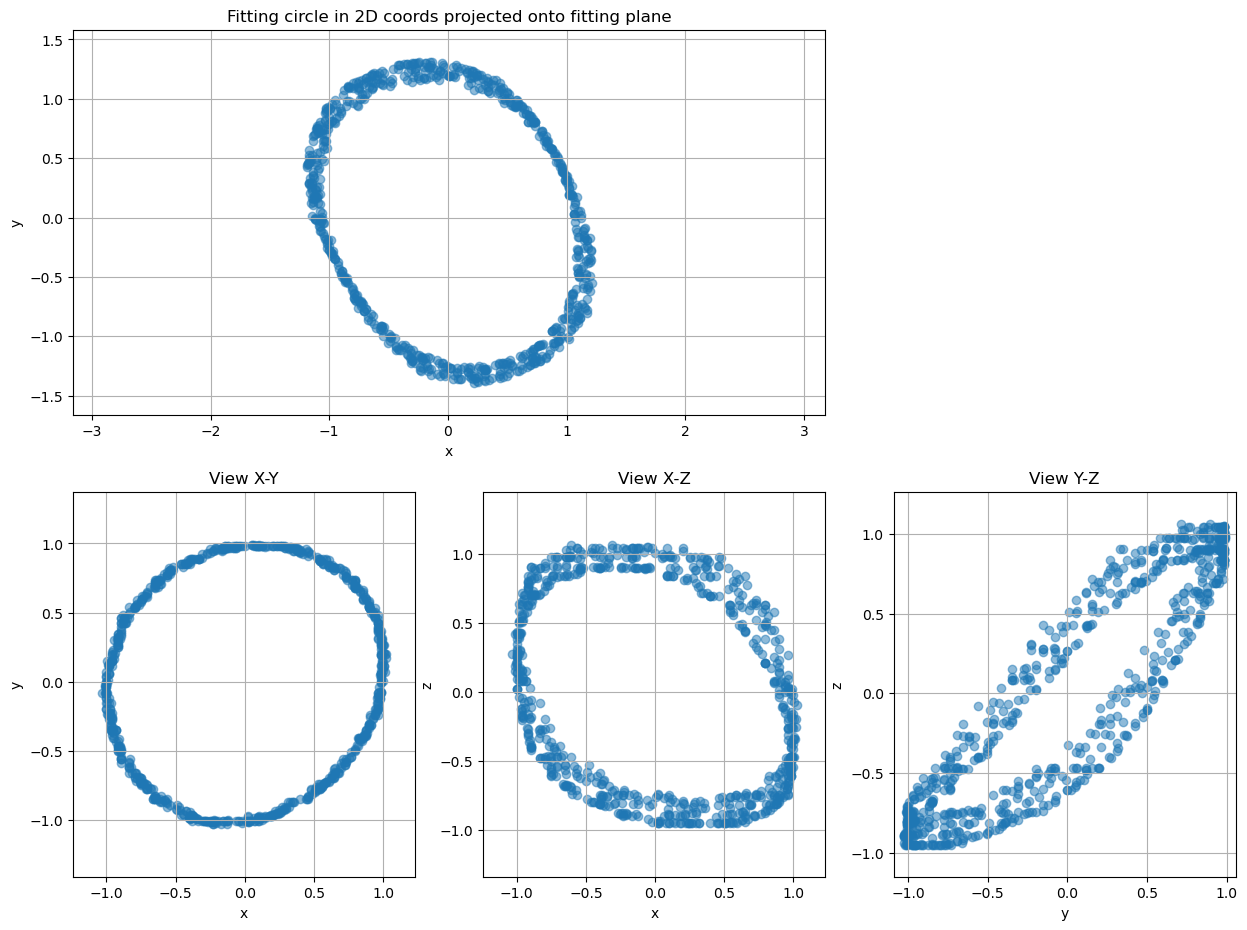

In [28]:
%matplotlib inline
hxd = (HX-np.nanmean(HXd))/np.std(HXd)/np.sqrt(2)
hyd = (HY-np.nanmean(HYd))/np.std(HYd)/np.sqrt(2)
hzd = (HZ-np.nanmean(HZd))/np.std(HZd)/np.sqrt(2)
hx = (HX-np.nanmean(HX))/np.std(HX)/np.sqrt(2)
hy = (HY-np.nanmean(HY))/np.std(HY)/np.sqrt(2)
hz = (HZ-np.nanmean(HZ))/np.std(HZ)/np.sqrt(2)



P = np.append(np.expand_dims(hx, axis=1), np.expand_dims(hy, axis=1), axis=1)
P = np.append(P, np.expand_dims(hz, axis=1), axis=1)

Pd = np.append(np.expand_dims(hxd, axis=1), np.expand_dims(hyd, axis=1), axis=1)
Pd = np.append(Pd, np.expand_dims(hzd, axis=1), axis=1)

#-------------------------------------------------------------------------------
# Init figures
#-------------------------------------------------------------------------------
fig = figure(figsize=(15,11))
alpha_pts = 0.5
figshape = (2,3)
ax = [None]*4
ax[0] = subplot2grid(figshape, loc=(0,0), colspan=2)
ax[1] = subplot2grid(figshape, loc=(1,0))
ax[2] = subplot2grid(figshape, loc=(1,1))
ax[3] = subplot2grid(figshape, loc=(1,2))
i = 0
ax[i].set_title('Fitting circle in 2D coords projected onto fitting plane')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()
i = 1
ax[i].scatter(P[:,0], P[:,1], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()
i = 2
ax[i].scatter(P[:,0], P[:,2], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()
i = 3
ax[i].scatter(P[:,1], P[:,2], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()

#-------------------------------------------------------------------------------
# (1) Fitting plane by SVD for the mean-centered data
# Eq. of plane is <p,n> + d = 0, where p is a point on plane and n is normal vector
#-------------------------------------------------------------------------------
P_mean = P.mean(axis=0)
P_centered = P - P_mean
U,s,V = linalg.svd(P_centered)

# Normal vector of fitting plane is given by 3rd column in V
# Note linalg.svd returns V^T, so we need to select 3rd row from V^T
normal = V[2,:]
d = -dot(P_mean, normal)  # d = -<p,n>


P_meand = Pd.mean(axis=0)
P_centeredd = Pd - P_meand
Ud,sd,Vd = linalg.svd(P_centeredd)

# Normal vector of fitting plane is given by 3rd column in V
# Note linalg.svd returns V^T, so we need to select 3rd row from V^T
normal_d = Vd[2,:]
d_d = -dot(P_meand, normal_d)  # d = -<p,n>

#-------------------------------------------------------------------------------
# (2) Project points to coords X-Y in 2D plane
#-------------------------------------------------------------------------------
P_xy = rodrigues_rot(P_centered, normal, [0,0,1])

ax[0].scatter(P_xy[:,0], P_xy[:,1], alpha=alpha_pts, label='Projected points')

#-------------------------------------------------------------------------------
# (3) Fit circle in new 2D coords
#-------------------------------------------------------------------------------
#xc, yc, r = fit_circle_2d(P_xy[:,0], P_xy[:,1])
xc, yc, a, b, theta = fit_circle_2d(P_xy[:,0], P_xy[:,1])



#--- Generate circle points in 2D
t = linspace(0, 2*pi, 100)
#xx = xc + r*cos(t)
#yy = yc + r*sin(t)

xx = a*cos(t)+xc
yy = yc + b*sin(t)

R_ellipse = np.array([[np.cos(-theta), np.sin(-theta)], [-np.sin(-theta), np.cos(-theta)]])
#ellipse_out=np.matmul(R, np.array([xx, yy]))
ellipse_out = np.array([xx, yy])
R_points = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

#points_out = np.matmul(R_points, np.array([P_xy[:, 0], P_xy[:, 1]]))
ax[0].scatter(points_out[0, :], points_out[1, :], alpha=alpha_pts, label='Projected points')


xx = ellipse_out[0]
yy = ellipse_out[1]
ax[0].plot(xx, yy, 'k--', lw=2, label='Fitting circle')
ax[0].plot(xc, yc, 'k+', ms=10)
#ax[0].scatter(points_out[0, :]/a, points_out[1, :]/b, alpha=alpha_pts, label='Projected points scaled')
ax[0].plot(xx/a, yy/b, 'k--')
ax[0].legend()

#-------------------------------------------------------------------------------
# (4) Transform circle center back to 3D coords
#-------------------------------------------------------------------------------
C = rodrigues_rot(np.array([xc,yc,0]), [0,0,1], normal) + P_mean
C = C.flatten()

#--- Generate points for fitting circle
t = linspace(0, 2*pi, 100)
u = P[0] - C
P_fitcircle = generate_circle_by_vectors(t, C, a, b, normal, u, theta)

ax[1].plot(P_fitcircle[:,0], P_fitcircle[:,1], 'k--', lw=2, label='Fitting circle')
ax[2].plot(P_fitcircle[:,0], P_fitcircle[:,2], 'k--', lw=2, label='Fitting circle')
ax[3].plot(P_fitcircle[:,1], P_fitcircle[:,2], 'k--', lw=2, label='Fitting circle')
ax[3].legend()

#--- Generate points for fitting arc
u = P[0] - C
v = P[-1] - C
theta = angle_between(u, v, normal)

# t = linspace(0, theta, 100)
# P_fitarc = generate_circle_by_vectors(t, C, r, normal, u)

# ax[1].plot(P_fitarc[:,0], P_fitarc[:,1], 'k-', lw=3, label='Fitting arc')
# ax[2].plot(P_fitarc[:,0], P_fitarc[:,2], 'k-', lw=3, label='Fitting arc')
# ax[3].plot(P_fitarc[:,1], P_fitarc[:,2], 'k-', lw=3, label='Fitting arc')
# ax[1].plot(C[0], C[1], 'k+', ms=10)
# ax[2].plot(C[0], C[2], 'k+', ms=10)
# ax[3].plot(C[1], C[2], 'k+', ms=10)
# ax[3].legend()

print('Fitting plane: n = %s' % np.array_str(normal, precision=4))
#print('Fitting circle: center = %s, r = %.4g' % (np.array_str(C, precision=4), r))
print('Fitting arc: u = %s, θ = %.4g' % (np.array_str(u, precision=4), theta*180/pi))

<IPython.core.display.Javascript object>


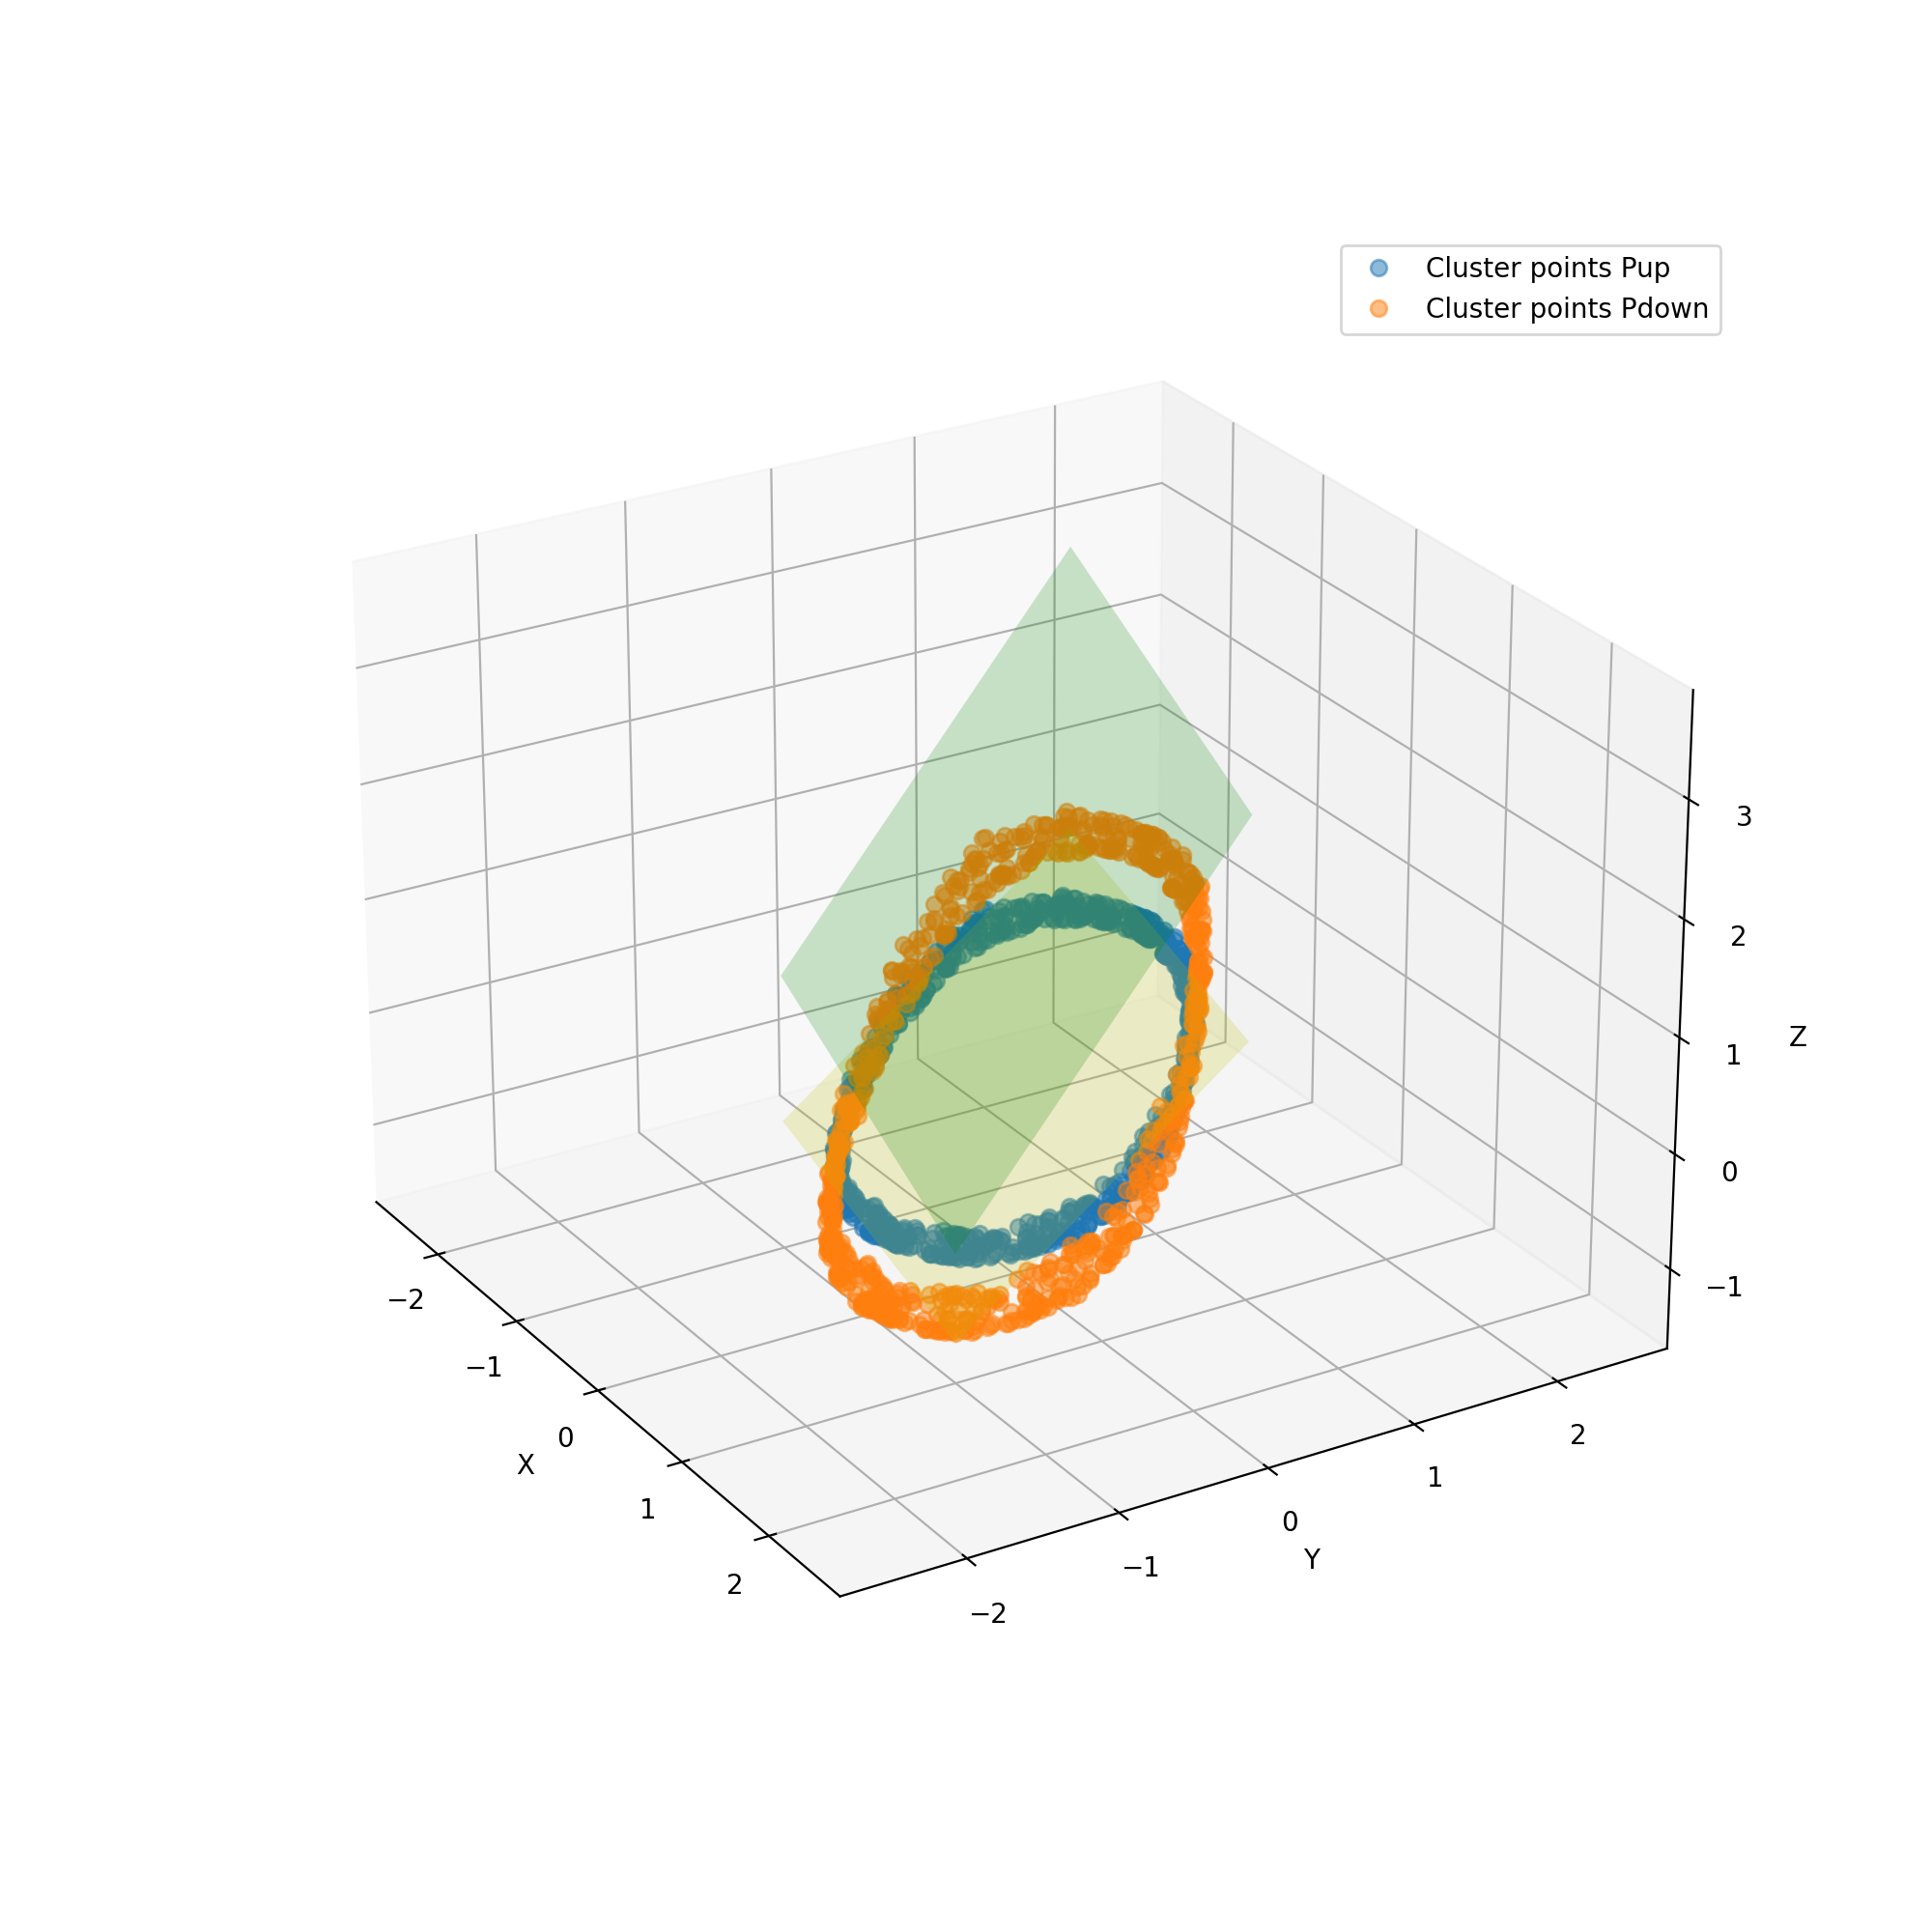

In [29]:
%matplotlib notebook
fig = figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,projection='3d')

#Pup = P

ax.plot(*P_centered.T, ls='', marker='o', alpha=0.5, label='Cluster points Pup')

#--- Plot fitting plane
xx, yy = meshgrid(linspace(-1,1,11), linspace(-1,1,11))
zz = (-normal[0]*xx - normal[1]*yy - d) / normal[2]
ax.plot_surface(xx, yy, zz, rstride=2, cstride=2, color='y' ,alpha=0.2, shade=False)


ax.plot(*P_centeredd.T, ls='', marker='o', alpha=0.5, label='Cluster points Pdown')

#--- Plot fitting plane
xx, yy = meshgrid(linspace(-1,1,11), linspace(-1,1,11))
zz = (-normal_d[0]*xx - normal_d[1]*yy - d_d) / normal_d[2]
ax.plot_surface(xx, yy, zz, rstride=2, cstride=2, color='g' ,alpha=0.2, shade=False)

#--- Plot fitting circle
#ax.plot(*P_fitcircle.T, color='k', ls='--', lw=2, label='Fitting circle')
#ax.plot(*P_fitarc.T, color='k', ls='-', lw=3, label='Fitting arc')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

ax.set_aspect('auto', 'datalim')
set_axes_equal_3d(ax)

In [173]:
normal

array([-0.27253944,  0.66702874, -0.69339377])

In [174]:
normal_d

array([-0.33009334,  0.79156271, -0.51426341])

In [187]:
hx = points_out[0, :]/a
hy = points_out[1, :]/b

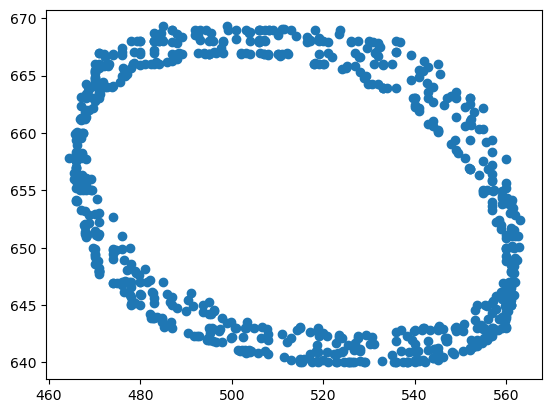

In [102]:
plt.scatter(HX, HZ)


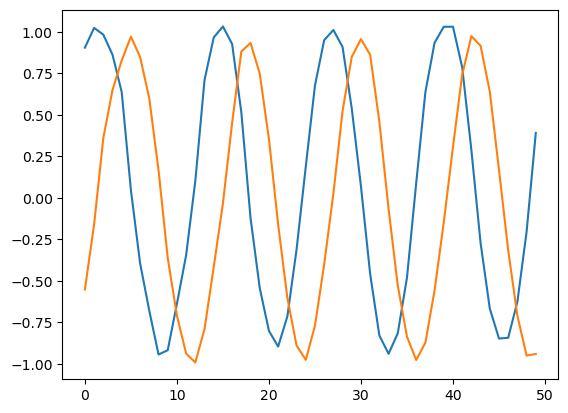

In [194]:
plt.plot(hx[0:50])
# plt.plot(E_x[0:50])
plt.plot(hy[0:50])

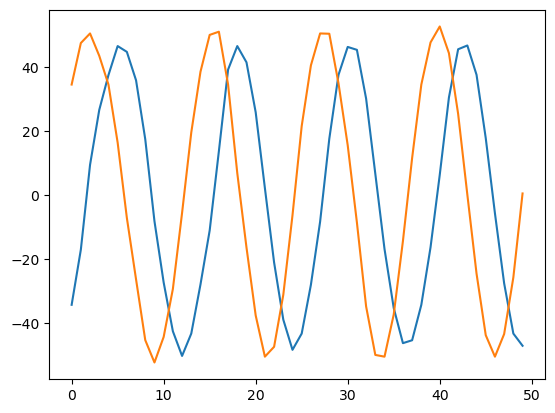

In [196]:
plt.plot(HX[0:50]-np.nanmean(HX))
plt.plot(HY[0:50]-np.nanmean(HY))

In [140]:
AZ = (EFR["AY"][0, :]-(2**9))/((2**10)/4)
#AX = AX-np.nanmean(AX)
#AX = signal.detrend(AX)
facg=9.81
#AX=AX*facg

<IPython.core.display.Javascript object>


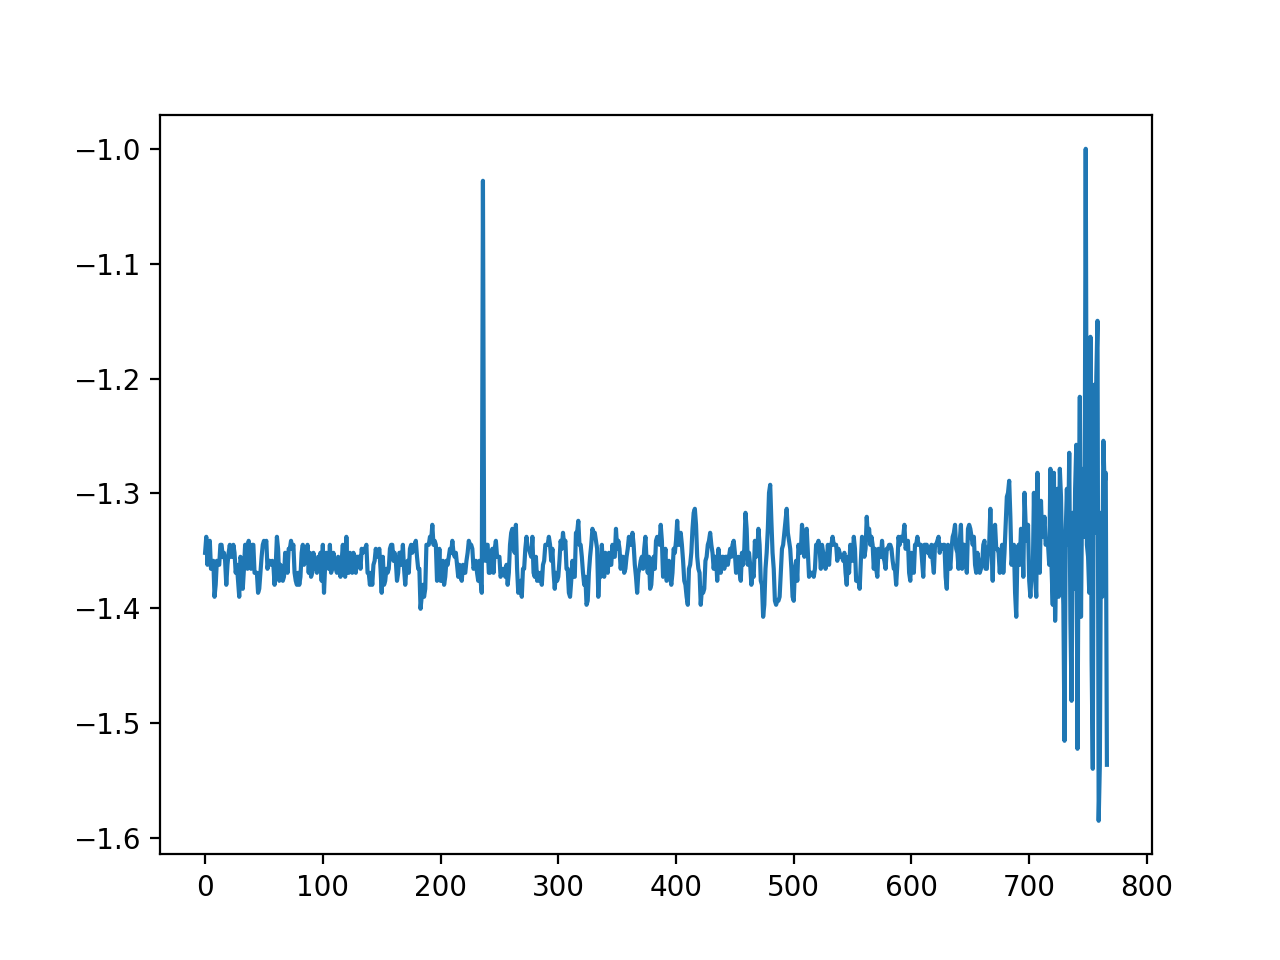

In [141]:
plt.figure()
#plt.plot(AZ[100:150])
#plt.plot(np.flip(AX[100:150]*facg))
plt.plot(AZ*facg)

(-2.0, 2.0)

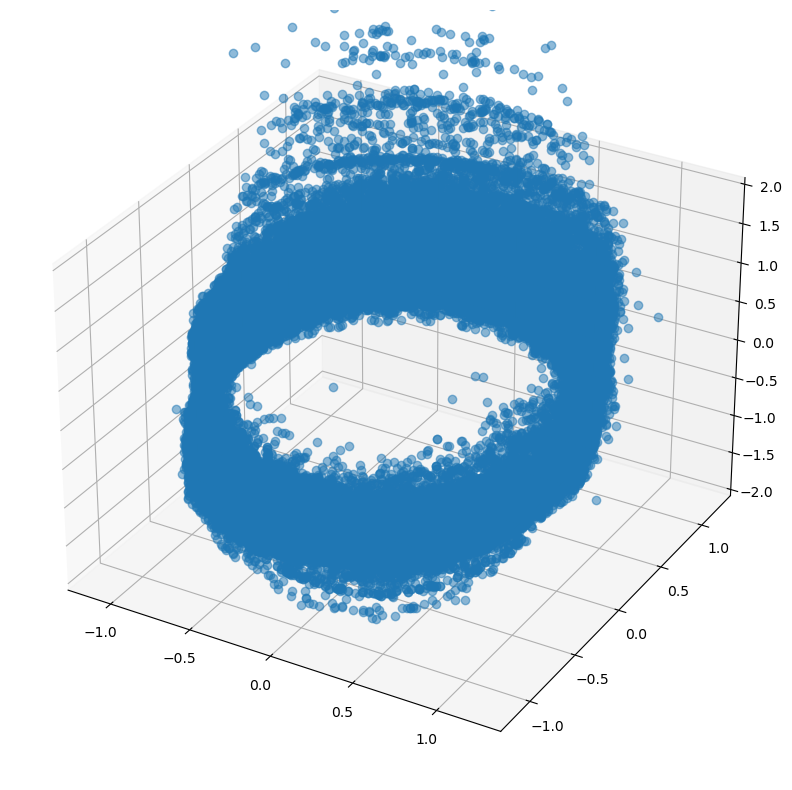

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,projection='3d')

#Pup = P
#nomral_up = normal

ax.plot(big_mag_store[:, 0], big_mag_store[:, 1], big_mag_store[:, 2], ls='', marker='o', alpha=0.5, label='Cluster points Pup')
ax.set_zlim([-2, 2])

#plt.scatter(big_mag_store[:, 0], big_mag_store[:, 1])

#plt.figure()
#plt.scatter(big_mag_store[:, 1], big_mag_store[:, 2])

<IPython.core.display.Javascript object>


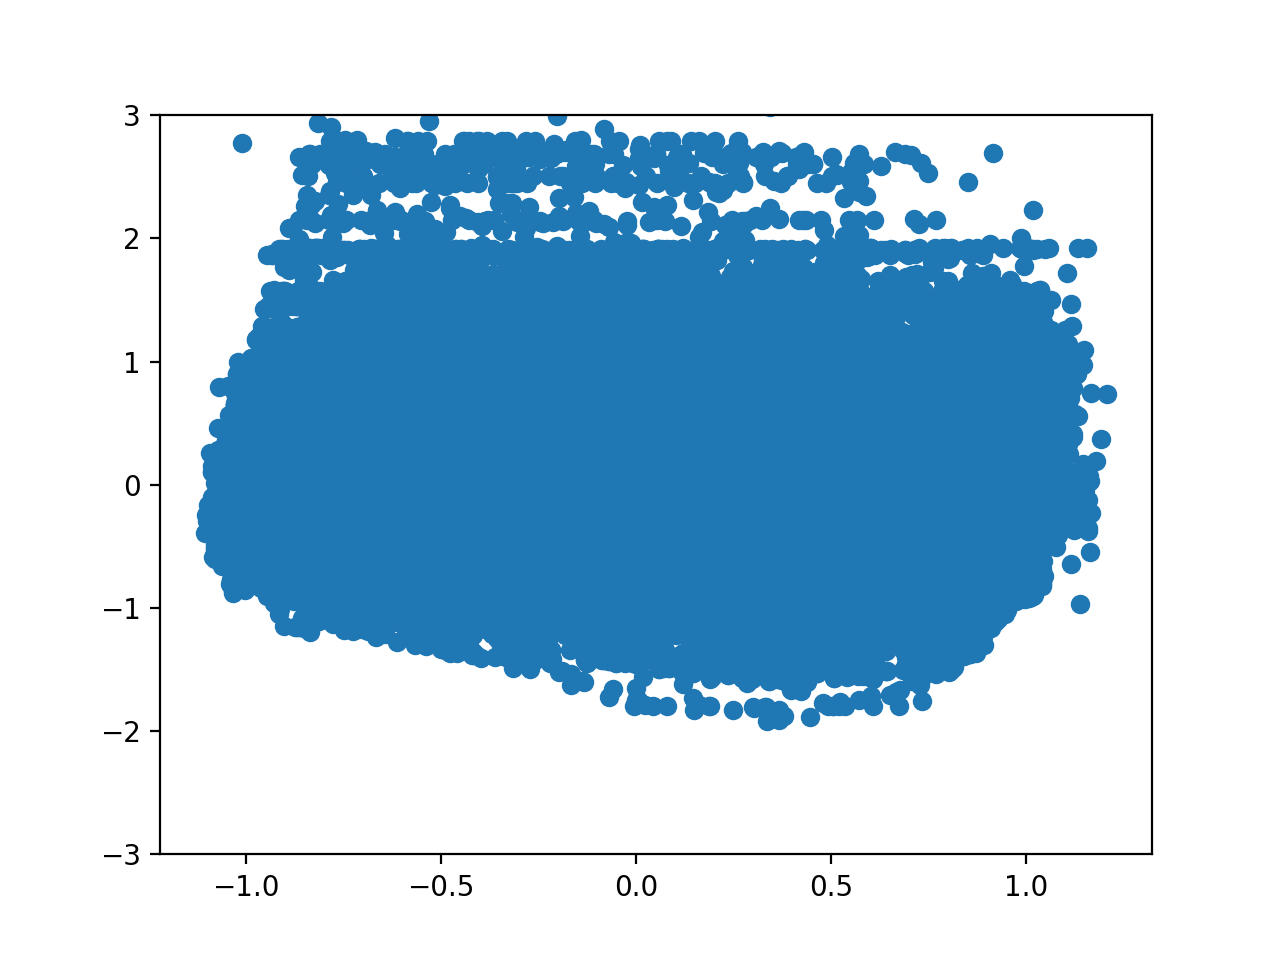

(-3.0, 3.0)

In [144]:
plt.figure()
plt.scatter(big_mag_store[:, 0], big_mag_store[:, 2])

plt.ylim(-3, 3)


plt.plot(down_normals)

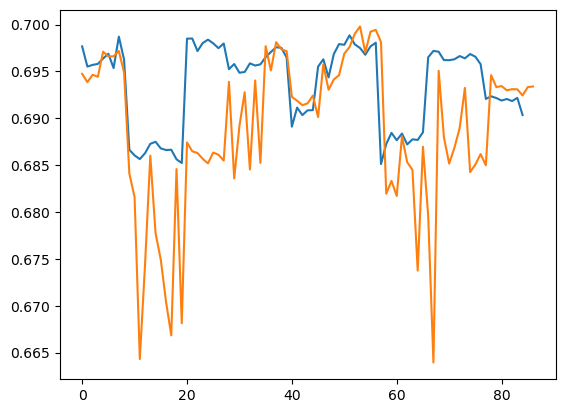

In [178]:
plt.plot(np.abs(down_normals))
plt.plot(np.abs(up_normals))

In [181]:
np.nanmean(np.abs(up_normals))

0.6888722333258928

In [180]:
np.nanmean(np.abs(down_normals))

0.6936284064334042

In [189]:
theta.shape

(59,)

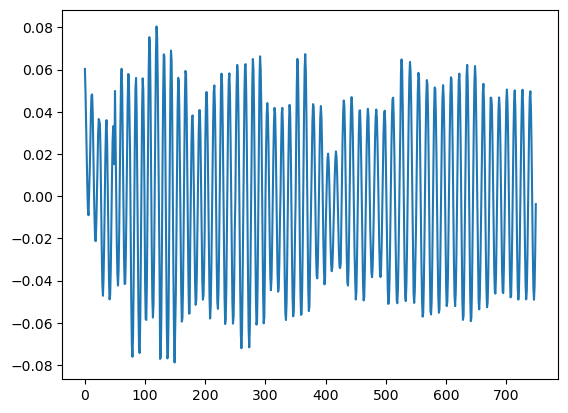

In [25]:
plt.plot(AZfit)

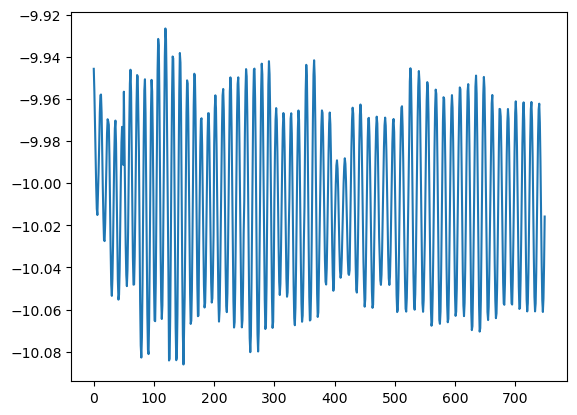

In [49]:
plt.plot(AZfit)

In [28]:
np.nanmean(np.sqrt(np.square(AZfit)))

0.033760576639793094

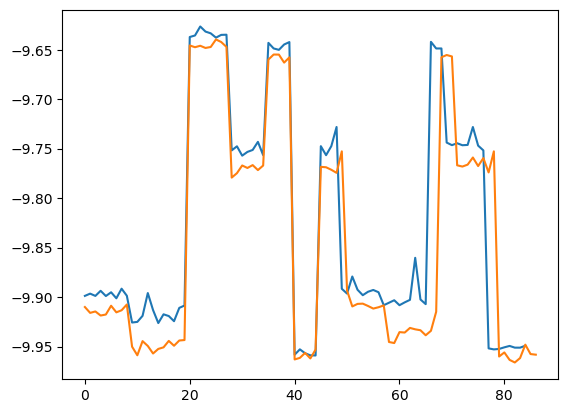

In [46]:
plt.plot(down_mags)
plt.plot(up_mags)

In [53]:
time_store_sorted

array([1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.])

In [41]:
up

True

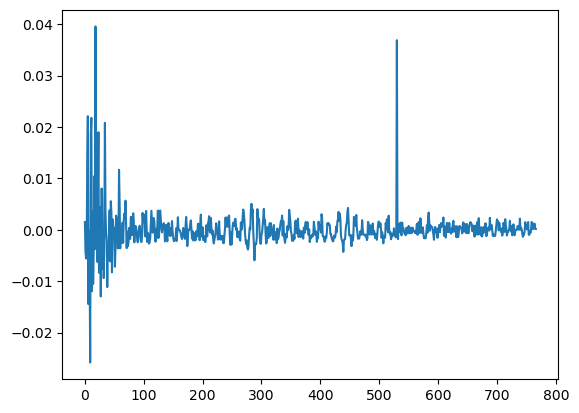

In [97]:
plt.plot(AY)